# Connecting the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# importation

In [2]:
import itertools
import os
import random
import six
import numpy as np
import cv2

In [3]:
try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence
try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found, disabling progress bars")

def tqdm(iter):
    return iter

#### Moving to the locals files 

In [4]:
import sys
import os
pathg = '/content/drive/My Drive/mobilenet/'
%cd '/content/drive/My Drive/mobilenet/'
# path to pac
sys.path.append(pathg)
os.getcwd()

/content/drive/My Drive/mobilenet


'/content/drive/My Drive/mobilenet'

# Model

In [5]:

from keras.models import *
from keras.layers import *
import json
import os
import six
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys
from keras_segmentation.models.mobilenet import get_mobilenet_encoder

Verifying training dataset


100%|██████████| 367/367 [00:05<00:00, 71.54it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - ETA: 0s - loss: 0.8820 - accuracy: 0.7456
Epoch 1: saving model to /content/drive/My Drive/mobilenet/tmp/vgg_unet_1.00001
512/512 [==============================] - 125s 229ms/step - loss: 0.8820 - accuracy: 0.7456
Epoch 2/5
512/512 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8478
Epoch 2: saving model to /content/drive/My Drive/mobilenet/tmp/vgg_unet_1.00002
512/512 [==============================] - 121s 237ms/step - loss: 0.4896 - accuracy: 0.8478
Epoch 3/5
512/512 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8768
Epoch 3: saving model to /content/drive/My Drive/mobilenet/tmp/vgg_unet_1.00003
512/512 [==============================] - 124s 242ms/step - loss: 0.3908 - accuracy: 0.8768
Epoch 4/5
512/512 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8965
Epoch 4: saving model to /content/drive/My Drive/mobilenet/tmp/vgg_unet_1.00004
51

101it [00:24,  4.18it/s]

{'frequency_weighted_IU': 0.8112253100184742, 'mean_IU': 0.1272429705099768, 'class_wise_IU': array([0.94110309, 0.8264252 , 0.08109064, 0.93400076, 0.78521685,
       0.81645045, 0.35420557, 0.41272657, 0.62564852, 0.25432099,
       0.26234623, 0.19585661, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])}


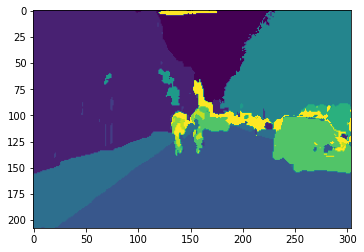

In [6]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=51 ,  input_height=416, input_width=608  )

model.train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/content/drive/My Drive/mobilenet/tmp/vgg_unet_1" , epochs=5
)

out = model.predict_segmentation(
    inp="dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/content/drive/My Drive/mobilenet/tmp/out.png"
)

import matplotlib.pyplot as plt
plt.imshow(out)

# evaluating the model 
print(model.evaluate_segmentation( inp_images_dir="dataset1/images_prepped_test/"  , annotations_dir="dataset1/annotations_prepped_test/" ) )


In [12]:
import glob
import random
import json
import os
import six

import cv2
import numpy as np
from tqdm import tqdm
from time import time
from keras_segmentation.train import find_latest_checkpoint
from keras_segmentation.data_utils.data_loader import get_image_array, get_segmentation_array, DATA_LOADER_SEED, class_colors, get_pairs_from_paths
from keras_segmentation.models.config import IMAGE_ORDERING


random.seed(DATA_LOADER_SEED)


def model_from_checkpoint_path(checkpoints_path):

    from keras_segmentation.models.all_models import model_from_name
    assert (os.path.isfile(checkpoints_path+"_config.json")
            ), "Checkpoint not found."
    model_config = json.loads(
        open(checkpoints_path+"_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    assert (latest_weights is not None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](
        model_config['n_classes'], input_height=model_config['input_height'],
        input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    status = model.load_weights(latest_weights)

    if status is not None:
        status.expect_partial()

    return model


def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img


def get_legends(class_names, colors=class_colors):

    n_classes = len(class_names)
    legend = np.zeros(((len(class_names) * 25) + 25, 125, 3),
                      dtype="uint8") + 255

    class_names_colors = enumerate(zip(class_names[:n_classes],
                                       colors[:n_classes]))

    for (i, (class_name, color)) in class_names_colors:
        color = [int(c) for c in color]
        cv2.putText(legend, class_name, (5, (i * 25) + 17),
                    cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)
        cv2.rectangle(legend, (100, (i * 25)), (125, (i * 25) + 25),
                      tuple(color), -1)

    return legend


def overlay_seg_image(inp_img, seg_img):
    orininal_h = inp_img.shape[0]
    orininal_w = inp_img.shape[1]
    seg_img = cv2.resize(seg_img, (orininal_w, orininal_h), interpolation=cv2.INTER_NEAREST)

    fused_img = (inp_img/2 + seg_img/2).astype('uint8')
    return fused_img


def concat_lenends(seg_img, legend_img):

    new_h = np.maximum(seg_img.shape[0], legend_img.shape[0])
    new_w = seg_img.shape[1] + legend_img.shape[1]

    out_img = np.zeros((new_h, new_w, 3)).astype('uint8') + legend_img[0, 0, 0]

    out_img[:legend_img.shape[0], :  legend_img.shape[1]] = np.copy(legend_img)
    out_img[:seg_img.shape[0], legend_img.shape[1]:] = np.copy(seg_img)

    return out_img


def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    if (prediction_height is not None) and (prediction_width is not None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height), interpolation=cv2.INTER_NEAREST)
        if inp_img is not None:
            inp_img = cv2.resize(inp_img,
                                 (prediction_width, prediction_height))

    if overlay_img:
        assert inp_img is not None
        seg_img = overlay_seg_image(inp_img, seg_img)

    if show_legends:
        assert class_names is not None
        legend_img = get_legends(class_names, colors=colors)

        seg_img = concat_lenends(seg_img, legend_img)

    return seg_img


def predict(model=None, inp=None, out_fname=None,
            checkpoints_path=None, overlay_img=False,
            class_names=None, show_legends=False, colors=class_colors,
            prediction_width=None, prediction_height=None,
            read_image_type=1):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)

    assert (inp is not None)
    assert ((type(inp) is np.ndarray) or isinstance(inp, six.string_types)),\
        "Input should be the CV image or the input file name"

    if isinstance(inp, six.string_types):
        inp = cv2.imread(inp, read_image_type)

    assert (len(inp.shape) == 3 or len(inp.shape) == 1 or len(inp.shape) == 4), "Image should be h,w,3 "

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = get_image_array(inp, input_width, input_height,
                        ordering=IMAGE_ORDERING)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

    seg_img = visualize_segmentation(pr, inp, n_classes=n_classes,
                                     colors=colors, overlay_img=overlay_img,
                                     show_legends=show_legends,
                                     class_names=class_names,
                                     prediction_width=prediction_width,
                                     prediction_height=prediction_height)

    if out_fname is not None:
        cv2.imwrite(out_fname, seg_img)

    return pr


def predict_multiple(model=None, inps=None, inp_dir=None, out_dir=None,
                     checkpoints_path=None, overlay_img=False,
                     class_names=None, show_legends=False, colors=class_colors,
                     prediction_width=None, prediction_height=None, read_image_type=1):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)

    if inps is None and (inp_dir is not None):
        inps = glob.glob(os.path.join(inp_dir, "*.jpg")) + glob.glob(
            os.path.join(inp_dir, "*.png")) + \
            glob.glob(os.path.join(inp_dir, "*.jpeg"))
        inps = sorted(inps)

    assert type(inps) is list

    all_prs = []

    if not out_dir is None:
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)


    for i, inp in enumerate(tqdm(inps)):
        if out_dir is None:
            out_fname = None
        else:
            if isinstance(inp, six.string_types):
                out_fname = os.path.join(out_dir, os.path.basename(inp))
            else:
                out_fname = os.path.join(out_dir, str(i) + ".jpg")

        pr = predict(model, inp, out_fname,
                     overlay_img=overlay_img, class_names=class_names,
                     show_legends=show_legends, colors=colors,
                     prediction_width=prediction_width,
                     prediction_height=prediction_height, read_image_type=read_image_type)

        all_prs.append(pr)

    return all_prs


def set_video(inp, video_name):
    cap = cv2.VideoCapture(inp)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    size = (video_width, video_height)
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    video = cv2.VideoWriter(video_name, fourcc, fps, size)
    return cap, video, fps


def predict_video(model=None, inp=None, output=None,
                  checkpoints_path=None, display=False, overlay_img=True,
                  class_names=None, show_legends=False, colors=class_colors,
                  prediction_width=None, prediction_height=None):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)
    n_classes = model.n_classes

    cap, video, fps = set_video(inp, output)
    while(cap.isOpened()):
        prev_time = time()
        ret, frame = cap.read()
        if frame is not None:
            pr = predict(model=model, inp=frame)
            fused_img = visualize_segmentation(
                pr, frame, n_classes=n_classes,
                colors=colors,
                overlay_img=overlay_img,
                show_legends=show_legends,
                class_names=class_names,
                prediction_width=prediction_width,
                prediction_height=prediction_height
                )
        else:
            break
        print("FPS: {}".format(1/(time() - prev_time)))
        if output is not None:
            video.write(fused_img)
        if display:
            cv2.imshow('Frame masked', fused_img)
            if cv2.waitKey(fps) & 0xFF == ord('q'):
                break
    cap.release()
    if output is not None:
        video.release()
    cv2.destroyAllWindows()


def evaluate(model=None, inp_images=None, annotations=None,
             inp_images_dir=None, annotations_dir=None, checkpoints_path=None, read_image_type=1):

    if model is None:
        assert (checkpoints_path is not None),\
                "Please provide the model or the checkpoints_path"
        model = model_from_checkpoint_path(checkpoints_path)

    if inp_images is None:
        assert (inp_images_dir is not None),\
                "Please provide inp_images or inp_images_dir"
        assert (annotations_dir is not None),\
            "Please provide inp_images or inp_images_dir"

        paths = get_pairs_from_paths(inp_images_dir, annotations_dir)
        paths = list(zip(*paths))
        inp_images = list(paths[0])
        annotations = list(paths[1])

    assert type(inp_images) is list
    assert type(annotations) is list

    tp = np.zeros(model.n_classes)
    fp = np.zeros(model.n_classes)
    fn = np.zeros(model.n_classes)
    n_pixels = np.zeros(model.n_classes)

    for inp, ann in tqdm(zip(inp_images, annotations)):
        pr = predict(model, inp, read_image_type=read_image_type)
        gt = get_segmentation_array(ann, model.n_classes,
                                    model.output_width, model.output_height,
                                    no_reshape=True, read_image_type=read_image_type)
        gt = gt.argmax(-1)
        pr = pr.flatten()
        gt = gt.flatten()

        for cl_i in range(model.n_classes):

            tp[cl_i] += np.sum((pr == cl_i) * (gt == cl_i))
            fp[cl_i] += np.sum((pr == cl_i) * ((gt != cl_i)))
            fn[cl_i] += np.sum((pr != cl_i) * ((gt == cl_i)))
            n_pixels[cl_i] += np.sum(gt == cl_i)

    cl_wise_score = tp / (tp + fp + fn + 0.000000000001)
    n_pixels_norm = n_pixels / np.sum(n_pixels)
    frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
    mean_IU = np.mean(cl_wise_score)

    return {
        "frequency_weighted_IU": frequency_weighted_IU,
        "mean_IU": mean_IU,
        "class_wise_IU": cl_wise_score
    }


loaded weights  /content/drive/My Drive/mobilenet/tmp/vgg_unet_1.00005


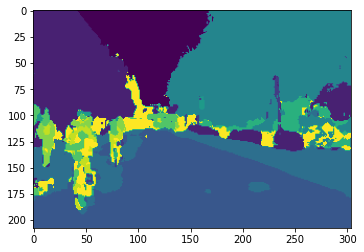

In [15]:
out = predict(model=None,
    inp="dataset1/images_prepped_test/0016E5_08117.png",
    out_fname="/content/drive/My Drive/mobilenet/tmp/0016E5_08117.png", checkpoints_path = "/content/drive/My Drive/mobilenet/tmp/vgg_unet_1"
)

import matplotlib.pyplot as plt
plt.imshow(out)
